In [13]:
import h5py
import numpy
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
from matplotlib import pyplot as plt
import itertools

import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.ensemble as skens
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

#Local scripts
from data import DecompData
from features import measurements
from plotting import plots
from loading import load_task_data_as_pandas_df

## Load/Extract session data

In [14]:
data_path = Path(os.path.abspath('')).parent / Path('data')
print(data_path)
if (not (data_path/'extracted_data.pkl').exists()):
    # load behavior data
    sessions = load_task_data_as_pandas_df.extract_session_data_and_save(root_paths=[data_path], mouse_ids=["GN06"], reextract=False)
    with open( data_path / 'extracted_data.pkl', 'wb') as handle:
        pkl.dump(sessions, handle)
else:
    # load saved data
    with open( data_path / 'extracted_data.pkl', 'rb') as handle:
        sessions = pkl.load(handle)
    print("Loaded pickled data.")

file_path = data_path / "GN06" / Path('2021-01-20_10-15-16/SVD_data/Vc.mat')
f = h5py.File(file_path, 'r')

frameCnt = np.array(f['frameCnt'])
trial_starts = np.cumsum(frameCnt[:, 1])
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts) )

C:\Master\Calcium_Analysis\data
Loaded pickled data.


## Define Conditions & additional Filters

In [15]:
#define different conds
modal_keys = ['visual', 'tactile', 'vistact']
modal_range = range(3)

side_keys = ['right', 'left']
side_range = range(2)

#filter for all conds
trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) & (svd.auto_reward == 0) & (svd.both_spouts == 1))

#set condition filter
cond_keys =  itertools.product(modal_keys,side_keys)
cond_keys_str = [f"{s}_{m}" for m, s in list(cond_keys)]
svd.conditions = ([(svd.modality == modal) & (svd.target_side_left == side) & trial_preselection for modal, side in itertools.product(modal_range,side_range)])

In [16]:
save_outputs = True
frames = 30  #### trial duration
baseline_mode = None  #### basline mode ('mean' / 'zscore' / None)
runs = 200  ### number of runs
comp = 1  ### number componants to use
n_rep = 20  ### number of repetition
n_comp_LDA = 1  ### number of LDA componants (conds -1)

In [17]:
features  = ['mean']
feature_data = {
    "mean": [measurements.mean(svd.conditions[i][30:75,:,:],comp) for i in range(len(svd.conditions))] #mean of stimulusframes for first cond
}
feature_label = ['mean']



(44, 45, 300)
(45, 45, 300)
(76, 45, 300)
(83, 45, 300)
(51, 45, 300)
(56, 45, 300)


In [20]:
cv = StratifiedShuffleSplit(n_rep, test_size=0.2, random_state=420)
perf = np.zeros([n_rep, len(features), 4])

for i_feat, feat in enumerate(features):


    data = np.concatenate(feature_data[feat])
    labels = np.concatenate([np.full((len(feature_data[feat][i])),cond_keys_str[i]) for i in range(len(feature_data[feat]))])
    #feature_labels[feat]
    #for i in range(len(feature_data[feat])):
         #= feature_data[feat][i]



    scaler = preprocessing.StandardScaler().fit( data )
    data = scaler.transform(data)

    cv_split = cv.split(data, labels)

    c_MLR = skppl.make_pipeline(skppc.StandardScaler(),
                                skllm.LogisticRegression(C=1, penalty='l2', multi_class='multinomial',
                                                         solver='lbfgs',
                                                         max_iter=500))
    c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

    c_LDA = skda.LinearDiscriminantAnalysis(n_components=n_comp_LDA, solver='eigen', shrinkage='auto')

    c_RF = skens.RandomForestClassifier(n_estimators=100, bootstrap=False)

    i = 0  ## counter
    for train_idx, test_idx in cv_split:
        print(f'\tRepetition {i:>3}/{n_rep}', end="\r" )
        c_MLR.fit(data[train_idx, :], labels[train_idx])
        c_1NN.fit(data[train_idx, :], labels[train_idx])
        c_LDA.fit(data[train_idx, :], labels[train_idx])
        c_RF .fit(data[train_idx, :], labels[train_idx])
        perf[i, i_feat, 0] = c_MLR.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 1] = c_1NN.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 2] = c_LDA.score(data[test_idx, :], labels[test_idx])
        perf[i, i_feat, 3] = c_RF.score(data[test_idx, :], labels[test_idx])
        i += 1
    print(f'\tRepetition {n_rep}/{n_rep}' )


	Repetition 20/200


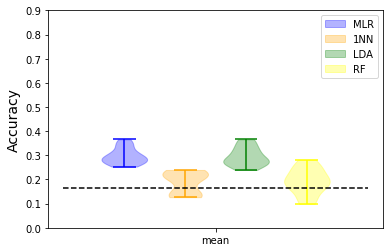

In [19]:
if save_outputs:
    np.save('perf_tasks.npy', perf)
plt.figure()
for i, feat in enumerate(features):
    v1 = plots.colored_violinplot(perf[:, i, 0], positions=np.arange(1) + i - 0.3, widths=[0.15], color="blue")
    v2 = plots.colored_violinplot(perf[:, i, 1], positions=np.arange(1) + i - 0.1, widths=[0.15], color="orange")
    v3 = plots.colored_violinplot(perf[:, i, 2], positions=np.arange(1) + i + 0.1, widths=[0.15], color="green")
    v4 = plots.colored_violinplot(perf[:, i, 3], positions=np.arange(1) + i + 0.3, widths=[0.15], color="yellow")
    if i == 0:
        plt.legend( [ v['bodies'][0] for v in [v1,v2,v3,v4]], [ "MLR", "1NN", "LDA","RF" ] )

plt.xticks(range(len(features)), [ feat for feat in features ])
plt.plot([-.5, len(features)-.5], [1/len(svd.conditions), 1/len(svd.conditions)], '--k')
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('Accuracy', fontsize=14)
plt.savefig("perf_tasks.png")
plt.show()
